In [12]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [13]:
df=pd.read_csv('Fridge_MotionSensor.csv')

df.head()

,entity_id,state,last_changed
0,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25T17:00:00.000Z
1,binary_sensor.motion_sensor_living_room_vibration,on,2024-07-25T17:02:52.499Z
2,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25T17:03:11.960Z
3,binary_sensor.motion_sensor_living_room_vibration,on,2024-07-25T17:03:14.599Z
4,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25T17:03:29.600Z


In [14]:
# Convert 'last_changed' to datetime and localize to UTC if necessary
df['last_changed'] = pd.to_datetime(df['last_changed'], errors='coerce')  # Convert to datetime, coerce errors

# Check if datetime column is timezone-aware, if not, localize to UTC
if df['last_changed'].dt.tz is None:
    df['last_changed'] = df['last_changed'].dt.tz_localize('UTC')

# Convert to the desired timezone (UTC+2)
df['last_changed'] = df['last_changed'].dt.tz_convert('Etc/GMT-2')

# Format 'last_changed' to 'YYYY MONTH DAY HOUR:MINUTE'
df['last_changed_formatted'] = df['last_changed'].dt.strftime('%Y %B %d %H:%M')
df.head()

,entity_id,state,last_changed,last_changed_formatted
0,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25 19:00:00+02:00,2024 July 25 19:00
1,binary_sensor.motion_sensor_living_room_vibration,on,2024-07-25 19:02:52.499000+02:00,2024 July 25 19:02
2,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25 19:03:11.960000+02:00,2024 July 25 19:03
3,binary_sensor.motion_sensor_living_room_vibration,on,2024-07-25 19:03:14.599000+02:00,2024 July 25 19:03
4,binary_sensor.motion_sensor_living_room_vibration,off,2024-07-25 19:03:29.600000+02:00,2024 July 25 19:03


In [15]:
# Filter rows where 'state' is 'on'

df_ordered = df[['last_changed_formatted', 'state']]




In [16]:
df['date'] = df['last_changed'].dt.strftime('%Y-%m-%d')

df_filtered = df[df['state'] == 'on'].copy()

opens_per_day = df_filtered.groupby('date').size().reset_index(name='opens')

opens_per_day.head()

,date,opens
0,2024-07-25,9
1,2024-07-26,36
2,2024-07-27,24
3,2024-07-28,25
4,2024-07-29,32


Text(0.5, 1.0, 'Fridge opens per day')

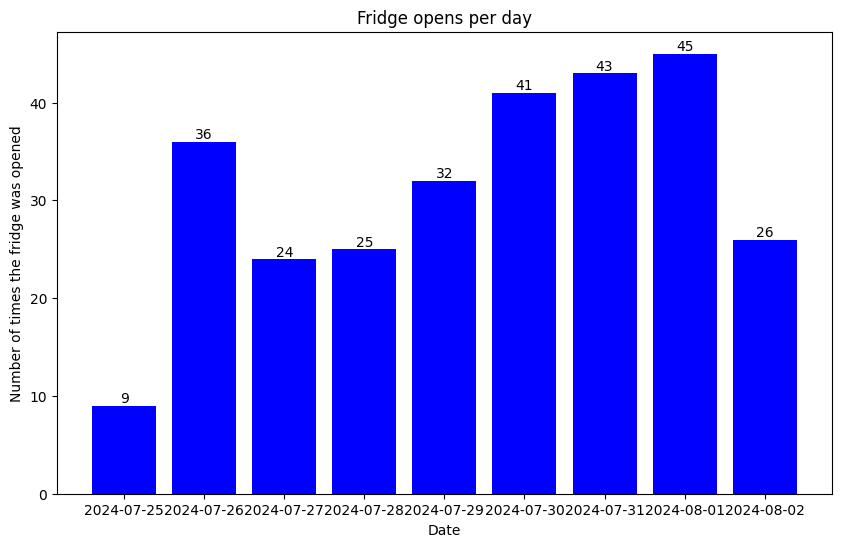

In [17]:
plt.figure(figsize=(10, 6))
plt.bar_label(plt.bar(opens_per_day['date'], opens_per_day['opens'],color='blue'))
plt.xlabel('Date')
plt.ylabel('Number of times the fridge was opened')
plt.title('Fridge opens per day')


In [18]:
df['time'] = df['last_changed'].dt.time

def categorize_time(time):
    if time >= pd.to_datetime('07:00').time() and time <= pd.to_datetime('12:00').time():
        return 'Morning'
    if time >= pd.to_datetime('12:00').time() and time <= pd.to_datetime('17:00').time():
        return 'Afternoon'
    if time >= pd.to_datetime('17:00').time() and time <= pd.to_datetime('23:59').time():
        return 'Evening'
    else:
        return 'Night'
    
df['time_interval'] = df['time'].apply(categorize_time)


In [19]:
df_filtered = df[df['state'] == 'on'].copy()

opens_per_interval = df_filtered.groupby(['date', 'time_interval']).size().reset_index(name='opens')
opens_per_interval.head()

,date,time_interval,opens
0,2024-07-25,Evening,9
1,2024-07-26,Afternoon,11
2,2024-07-26,Evening,12
3,2024-07-26,Morning,13
4,2024-07-27,Afternoon,9


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '2024-07-25'),
  Text(1, 0, '2024-07-26'),
  Text(2, 0, '2024-07-27'),
  Text(3, 0, '2024-07-28'),
  Text(4, 0, '2024-07-29'),
  Text(5, 0, '2024-07-30'),
  Text(6, 0, '2024-07-31'),
  Text(7, 0, '2024-08-01'),
  Text(8, 0, '2024-08-02')])

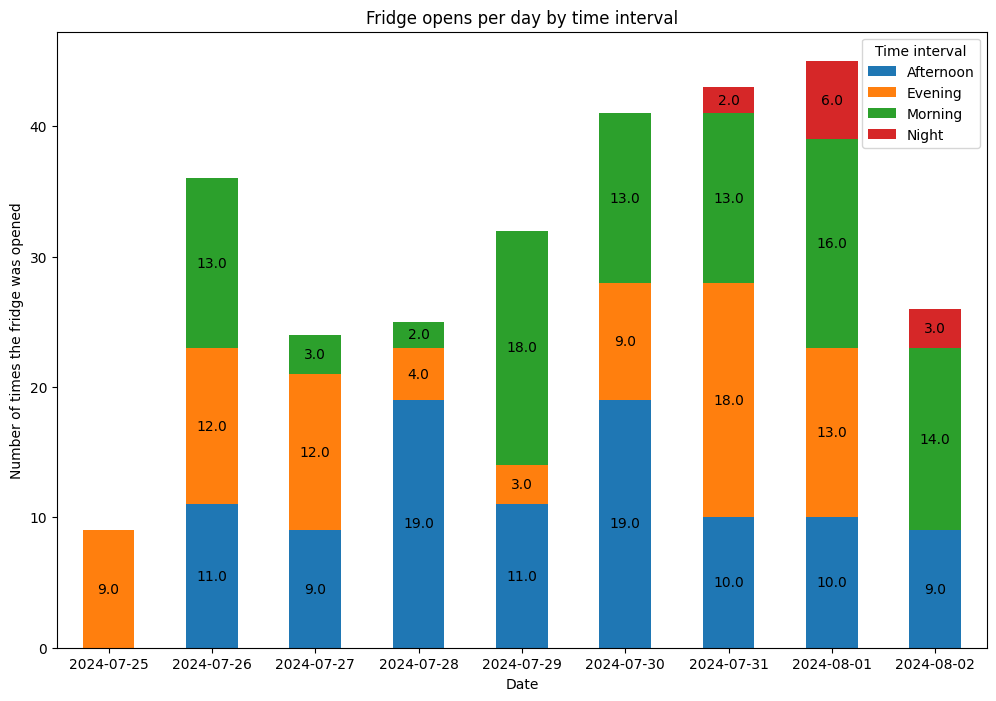

In [20]:
# Pivot the data for plotting
pivot_table = opens_per_interval.pivot(index='date', columns='time_interval', values='opens').fillna(0)
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels on the bars, but skip zeros
for container in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.xlabel('Date')
plt.ylabel('Number of times the fridge was opened')
plt.title('Fridge opens per day by time interval')
plt.legend(title='Time interval')
plt.xticks(rotation=0)


In [21]:
import plotly.express as px

# Create the interactive stacked bar chart using Plotly
fig = px.bar(opens_per_interval, 
             x='date', 
             y='opens', 
             color='time_interval', 
             title='Fridge opens per day by time interval',
             labels={'opens':'Number of times the fridge was opened', 'date':'Date'},
             barmode='stack')

fig.update_layout(xaxis_title='Date', yaxis_title='Number of times the fridge was opened', legend_title='Time interval')


In [22]:
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral
from bokeh.palettes import Viridis

from bokeh.io import show, output_notebook


output_notebook()

# Create a pivot table for plotting
pivot_table = opens_per_interval.pivot(index='date', columns='time_interval', values='opens').fillna(0)
dates = list(pivot_table.index)
intervals = list(pivot_table.columns)

data = {'dates': dates}
for interval in intervals:
    data[interval] = pivot_table[interval].tolist()

source = ColumnDataSource(data)





Loading BokehJS ...

In [23]:
colors = Spectral[len(intervals)] if len(intervals) <= 256 else Viridis[256]

p = figure(x_range=dates, height=400, width=800, title="Fridge opens per day by time interval",
           toolbar_location=None, tools="")

p.vbar_stack(intervals, x='dates', width=0.9, color=colors, source=source,
             legend_label=intervals)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

hover = HoverTool()
hover.tooltips = [("Date", "@dates"), ("Interval", "$name"), ("Opens", "@$name")]
p.add_tools(hover)

show(p)